In [1]:
import warnings
import pandas as pd

import sys
from pathlib import Path
# 상위 폴더를 Python 경로에 추가
sys.path.append(str(Path.cwd().parent))
from util.model_tuning import auto_model_tuning

warnings.filterwarnings('ignore')
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer   # 결측치값 대체.
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline


In [2]:
df = pd.read_csv("../data/merged_dataset_ver.1.csv")
df

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,date_registration,date_unregistration,sum_click,avg_score,banked_ratio,is_dropout
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,-159.0,NaN,934.0,82.000000,0.0,0
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,-53.0,NaN,1435.0,66.400000,0.0,0
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn,-92.0,12.0,281.0,0.000000,0.0,1
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,-52.0,NaN,2158.0,76.000000,0.0,0
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,-176.0,NaN,1034.0,54.400000,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32588,GGG,2014J,2640965,F,Wales,Lower Than A Level,10-20,0-35,0,30,N,Fail,-4.0,NaN,41.0,0.000000,0.0,0
32589,GGG,2014J,2645731,F,East Anglian Region,Lower Than A Level,40-50%,35-55,0,30,N,Distinction,-23.0,NaN,893.0,88.111111,0.0,0
32590,GGG,2014J,2648187,F,South Region,A Level or Equivalent,20-30%,0-35,0,30,Y,Pass,-129.0,NaN,312.0,76.666667,0.0,0
32591,GGG,2014J,2679821,F,South East Region,Lower Than A Level,90-100%,35-55,0,30,N,Withdrawn,-49.0,101.0,275.0,91.500000,0.0,1


In [3]:
df["final_result"].unique()

array(['Pass', 'Withdrawn', 'Fail', 'Distinction'], dtype=object)

In [4]:
# target_1: 'Withdrawn'이면 1, 아니면 0
df["target_1"] = (df["final_result"] == "Withdrawn").astype(int)

# target_2: 'Withdrawn' 또는 'Fail'이면 1, 아니면 0
df["target_2"] = df["final_result"].isin(["Withdrawn", "Fail"]).astype(int)

In [5]:
df

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,date_registration,date_unregistration,sum_click,avg_score,banked_ratio,is_dropout,target_1,target_2
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,-159.0,NaN,934.0,82.000000,0.0,0,0,0
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,-53.0,NaN,1435.0,66.400000,0.0,0,0,0
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn,-92.0,12.0,281.0,0.000000,0.0,1,1,1
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,-52.0,NaN,2158.0,76.000000,0.0,0,0,0
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,-176.0,NaN,1034.0,54.400000,0.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32588,GGG,2014J,2640965,F,Wales,Lower Than A Level,10-20,0-35,0,30,N,Fail,-4.0,NaN,41.0,0.000000,0.0,0,0,1
32589,GGG,2014J,2645731,F,East Anglian Region,Lower Than A Level,40-50%,35-55,0,30,N,Distinction,-23.0,NaN,893.0,88.111111,0.0,0,0,0
32590,GGG,2014J,2648187,F,South Region,A Level or Equivalent,20-30%,0-35,0,30,Y,Pass,-129.0,NaN,312.0,76.666667,0.0,0,0,0
32591,GGG,2014J,2679821,F,South East Region,Lower Than A Level,90-100%,35-55,0,30,N,Withdrawn,-49.0,101.0,275.0,91.500000,0.0,1,1,1


In [6]:
(df["target_1"] == df["is_dropout"]).all()
df[df["target_1"] != df["is_dropout"]]

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,date_registration,date_unregistration,sum_click,avg_score,banked_ratio,is_dropout,target_1,target_2
2777,BBB,2013J,362907,F,South West Region,Lower Than A Level,20-30%,35-55,2,60,N,Fail,-37.0,0.0,0.0,0.000000,0.0,1,0,1
2786,BBB,2013J,365288,F,South Region,A Level or Equivalent,70-80%,0-35,0,60,N,Fail,-75.0,0.0,9.0,0.000000,0.0,1,0,1
3340,BBB,2013J,554243,F,South West Region,Lower Than A Level,60-70%,0-35,0,60,N,Fail,-35.0,166.0,417.0,81.777778,0.0,1,0,1
6315,BBB,2014B,2512349,F,Yorkshire Region,Lower Than A Level,40-50%,35-55,0,60,N,Withdrawn,-17.0,NaN,0.0,0.000000,0.0,0,1,1
6484,BBB,2014J,271047,F,South West Region,Lower Than A Level,90-100%,0-35,0,60,N,Withdrawn,-25.0,NaN,7.0,0.000000,0.0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29978,FFF,2014J,2398260,M,London Region,Lower Than A Level,10-20,35-55,0,180,N,Withdrawn,-38.0,NaN,370.0,0.000000,0.0,0,1,1
30032,FFF,2014J,2622634,M,Ireland,A Level or Equivalent,10-20,35-55,1,60,N,Withdrawn,-29.0,NaN,17.0,0.000000,0.0,0,1,1
30562,GGG,2013J,590248,F,Yorkshire Region,Lower Than A Level,30-40%,0-35,0,30,N,Withdrawn,-16.0,NaN,297.0,59.375000,0.0,0,1,1
32149,GGG,2014J,646891,F,South Region,Lower Than A Level,10-20,35-55,0,60,N,Withdrawn,2.0,NaN,1.0,0.000000,0.0,0,1,1


In [7]:
(df["target_2"] == df["is_dropout"]).all()
df[df["target_2"] != df["is_dropout"]]

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,date_registration,date_unregistration,sum_click,avg_score,banked_ratio,is_dropout,target_1,target_2
18,AAA,2013J,74372,M,East Anglian Region,A Level or Equivalent,10-20,35-55,0,150,N,Fail,-50.0,NaN,116.0,48.500000,0.0,0,0,1
52,AAA,2013J,146188,F,West Midlands Region,A Level or Equivalent,20-30%,0-35,0,60,Y,Fail,-132.0,NaN,597.0,50.000000,0.0,0,0,1
53,AAA,2013J,147756,M,North Region,Lower Than A Level,60-70%,0-35,0,120,N,Fail,-92.0,NaN,611.0,68.666667,0.0,0,0,1
70,AAA,2013J,175991,F,North Western Region,A Level or Equivalent,80-90%,0-35,0,180,N,Fail,-57.0,NaN,138.0,37.600000,0.0,0,0,1
76,AAA,2013J,185439,M,London Region,HE Qualification,10-20,0-35,0,120,N,Fail,-12.0,NaN,427.0,74.000000,0.0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32562,GGG,2014J,1931810,F,London Region,Lower Than A Level,30-40%,35-55,0,30,N,Fail,-141.0,NaN,727.0,80.000000,0.0,0,0,1
32580,GGG,2014J,2378591,F,West Midlands Region,A Level or Equivalent,30-40%,35-55,1,30,N,Fail,-113.0,NaN,230.0,46.250000,0.0,0,0,1
32581,GGG,2014J,2456431,F,South Region,Lower Than A Level,70-80%,0-35,0,30,Y,Fail,-70.0,NaN,2151.0,81.833333,0.0,0,0,1
32582,GGG,2014J,2475886,F,East Anglian Region,Lower Than A Level,40-50%,35-55,0,90,N,Fail,-31.0,NaN,9.0,0.000000,0.0,0,0,1


In [8]:
df = df.rename(columns={"is_dropout": "target_0"})

In [9]:
df.columns

Index(['code_module', 'code_presentation', 'id_student', 'gender', 'region',
       'highest_education', 'imd_band', 'age_band', 'num_of_prev_attempts',
       'studied_credits', 'disability', 'final_result', 'date_registration',
       'date_unregistration', 'sum_click', 'avg_score', 'banked_ratio',
       'target_0', 'target_1', 'target_2'],
      dtype='object')

In [10]:
df = df.drop(["final_result", "id_student"], axis=1)

In [11]:
df.columns

Index(['code_module', 'code_presentation', 'gender', 'region',
       'highest_education', 'imd_band', 'age_band', 'num_of_prev_attempts',
       'studied_credits', 'disability', 'date_registration',
       'date_unregistration', 'sum_click', 'avg_score', 'banked_ratio',
       'target_0', 'target_1', 'target_2'],
      dtype='object')

In [12]:
df

,code_module,code_presentation,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,date_registration,date_unregistration,sum_click,avg_score,banked_ratio,target_0,target_1,target_2
0,AAA,2013J,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,-159.0,NaN,934.0,82.000000,0.0,0,0,0
1,AAA,2013J,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,-53.0,NaN,1435.0,66.400000,0.0,0,0,0
2,AAA,2013J,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,-92.0,12.0,281.0,0.000000,0.0,1,1,1
3,AAA,2013J,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,-52.0,NaN,2158.0,76.000000,0.0,0,0,0
4,AAA,2013J,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,-176.0,NaN,1034.0,54.400000,0.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32588,GGG,2014J,F,Wales,Lower Than A Level,10-20,0-35,0,30,N,-4.0,NaN,41.0,0.000000,0.0,0,0,1
32589,GGG,2014J,F,East Anglian Region,Lower Than A Level,40-50%,35-55,0,30,N,-23.0,NaN,893.0,88.111111,0.0,0,0,0
32590,GGG,2014J,F,South Region,A Level or Equivalent,20-30%,0-35,0,30,Y,-129.0,NaN,312.0,76.666667,0.0,0,0,0
32591,GGG,2014J,F,South East Region,Lower Than A Level,90-100%,35-55,0,30,N,-49.0,101.0,275.0,91.500000,0.0,1,1,1


In [13]:
for i, col in enumerate(df.columns):
    print(f"{i}: {col}")

0: code_module
1: code_presentation
2: gender
3: region
4: highest_education
5: imd_band
6: age_band
7: num_of_prev_attempts
8: studied_credits
9: disability
10: date_registration
11: date_unregistration
12: sum_click
13: avg_score
14: banked_ratio
15: target_0
16: target_1
17: target_2


In [14]:
df_0 = df.drop(["target_1", "target_2"], axis=1)
df_1 = df.drop(["target_0", "target_2"], axis=1)
df_2 = df.drop(["target_1", "target_0"], axis=1)

In [15]:
categorical_columns = ['code_module','code_presentation','gender','region','highest_education', 'imd_band', 'age_band', 'num_of_prev_attempts', 'disability']
categorical_columns_index = [0, 1, 2, 3, 4, 5, 6, 7, 9]  

numeric_columns = ['studied_credits', 'date_registration', 'date_unregistration', 'sum_click', 'avg_score', 'banked_ratio']
numeric_columns_index = [8, 10, 11, 12, 13, 14]

target_0 = "target_0"
target_1 = "target_1"
target_2 = "target_2"

In [16]:
df = df_0

In [17]:
df

,code_module,code_presentation,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,date_registration,date_unregistration,sum_click,avg_score,banked_ratio,target_0
0,AAA,2013J,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,-159.0,NaN,934.0,82.000000,0.0,0
1,AAA,2013J,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,-53.0,NaN,1435.0,66.400000,0.0,0
2,AAA,2013J,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,-92.0,12.0,281.0,0.000000,0.0,1
3,AAA,2013J,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,-52.0,NaN,2158.0,76.000000,0.0,0
4,AAA,2013J,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,-176.0,NaN,1034.0,54.400000,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32588,GGG,2014J,F,Wales,Lower Than A Level,10-20,0-35,0,30,N,-4.0,NaN,41.0,0.000000,0.0,0
32589,GGG,2014J,F,East Anglian Region,Lower Than A Level,40-50%,35-55,0,30,N,-23.0,NaN,893.0,88.111111,0.0,0
32590,GGG,2014J,F,South Region,A Level or Equivalent,20-30%,0-35,0,30,Y,-129.0,NaN,312.0,76.666667,0.0,0
32591,GGG,2014J,F,South East Region,Lower Than A Level,90-100%,35-55,0,30,N,-49.0,101.0,275.0,91.500000,0.0,1


In [18]:
# # ###############################
# # #결측치 처리
# # #결측치 처리 컬럼: imd_band(범주형 -> 최빈값으로 처리), date_registration(수치형 -> mean으로 처리)
# # # date_unregisitration(9999값으로 채우기)

# # # 1. 결측치 직접 처리: date_unregistration → 9999
df["date_unregistration"] = df["date_unregistration"].fillna(9999)

# # 2. 인코딩 직접 처리

# # 1) highest_education 학력별로 부여
education_order = {
    "No Formal Quals": 0,
    "Lower Than A Level": 1,
    "A Level Or Equivalent": 2,
    "He Qualification": 3,
    "Post Graduate Qualification": 4
}

# 문자열 정리 후 replace 사용
df["highest_education"] = df["highest_education"].str.strip().str.title()
df["highest_education"] = df["highest_education"].replace(education_order)
df["highest_education"].value_counts()

# 2) age_band 중간 값으로 변경
age_map = {
    "0-35": 30,     # 또는 17.5, 20도 가능 (의도에 따라)
    "35-55": 45,
    "55<=": 60      # 55세 이상이므로 60 또는 65로 추정
}

df["age_band"] = df["age_band"].str.strip().str.title()
df["age_band"] = df["age_band"].replace(age_map)
df["age_band"].value_counts()
# # merged_df["age_band"] = merged_df["age_band"].map(age_map)

# # # # 3) 취약계층 서열화 
imd_order = {
    "0-10%": 1,
    "10-20": 2,
    "20-30%": 3,
    "30-40%": 4,
    "40-50%": 5,
    "50-60%": 6,
    "60-70%": 7,
    "70-80%": 8,
    "80-90%": 9,
    "90-100%": 10
}

df["imd_band"] = df["imd_band"].str.strip().str.title()
df["imd_band"] = df["imd_band"].replace(imd_order)
df["imd_band"].value_counts()
# merged_df["imd_band"] = merged_df["imd_band"].map(imd_order)

df.info()

# # # # 1. 원래 컬럼 순서 저장
original_columns = df.columns.tolist()

# 2. ColumnTransformer 설정
na_transformer = ColumnTransformer([
    ("category_imputer", SimpleImputer(strategy="most_frequent"), ['imd_band']),
    ("number_imputer", SimpleImputer(strategy="mean"), ['date_registration'])
], remainder="passthrough")

# 3. 처리 대상 및 passthrough 대상 정리
processed_columns = ['imd_band', 'date_registration']
passthrough_columns = [col for col in df.columns if col not in processed_columns]

# 4. fit_transform 적용
na_values_array = na_transformer.fit_transform(df)

# 5. DataFrame으로 변환 + 컬럼 순서 복원
na_values_df = pd.DataFrame(na_values_array, columns=processed_columns + passthrough_columns)
na_values_df = na_values_df[original_columns]  # 순서 복원!
na_values_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   code_module           32593 non-null  object 
 1   code_presentation     32593 non-null  object 
 2   gender                32593 non-null  object 
 3   region                32593 non-null  object 
 4   highest_education     32593 non-null  int64  
 5   imd_band              31482 non-null  float64
 6   age_band              32593 non-null  int64  
 7   num_of_prev_attempts  32593 non-null  int64  
 8   studied_credits       32593 non-null  int64  
 9   disability            32593 non-null  object 
 10  date_registration     32548 non-null  float64
 11  date_unregistration   32593 non-null  float64
 12  sum_click             32593 non-null  float64
 13  avg_score             32593 non-null  float64
 14  banked_ratio          32593 non-null  float64
 15  target_0           

,code_module,code_presentation,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,date_registration,date_unregistration,sum_click,avg_score,banked_ratio,target_0
0,AAA,2013J,M,East Anglian Region,3,10.0,60,0,240,N,-159.0,9999.0,934.0,82.0,0.0,0
1,AAA,2013J,F,Scotland,3,3.0,45,0,60,N,-53.0,9999.0,1435.0,66.4,0.0,0
2,AAA,2013J,F,North Western Region,2,4.0,45,0,60,Y,-92.0,12.0,281.0,0.0,0.0,1
3,AAA,2013J,F,South East Region,2,6.0,45,0,60,N,-52.0,9999.0,2158.0,76.0,0.0,0
4,AAA,2013J,F,West Midlands Region,1,6.0,30,0,60,N,-176.0,9999.0,1034.0,54.4,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32588,GGG,2014J,F,Wales,1,2.0,30,0,30,N,-4.0,9999.0,41.0,0.0,0.0,0
32589,GGG,2014J,F,East Anglian Region,1,5.0,45,0,30,N,-23.0,9999.0,893.0,88.111111,0.0,0
32590,GGG,2014J,F,South Region,2,3.0,30,0,30,Y,-129.0,9999.0,312.0,76.666667,0.0,0
32591,GGG,2014J,F,South East Region,1,10.0,45,0,30,N,-49.0,101.0,275.0,91.5,0.0,1


In [19]:
df

,code_module,code_presentation,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,date_registration,date_unregistration,sum_click,avg_score,banked_ratio,target_0
0,AAA,2013J,M,East Anglian Region,3,10.0,60,0,240,N,-159.0,9999.0,934.0,82.000000,0.0,0
1,AAA,2013J,F,Scotland,3,3.0,45,0,60,N,-53.0,9999.0,1435.0,66.400000,0.0,0
2,AAA,2013J,F,North Western Region,2,4.0,45,0,60,Y,-92.0,12.0,281.0,0.000000,0.0,1
3,AAA,2013J,F,South East Region,2,6.0,45,0,60,N,-52.0,9999.0,2158.0,76.000000,0.0,0
4,AAA,2013J,F,West Midlands Region,1,6.0,30,0,60,N,-176.0,9999.0,1034.0,54.400000,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32588,GGG,2014J,F,Wales,1,2.0,30,0,30,N,-4.0,9999.0,41.0,0.000000,0.0,0
32589,GGG,2014J,F,East Anglian Region,1,5.0,45,0,30,N,-23.0,9999.0,893.0,88.111111,0.0,0
32590,GGG,2014J,F,South Region,2,3.0,30,0,30,Y,-129.0,9999.0,312.0,76.666667,0.0,0
32591,GGG,2014J,F,South East Region,1,10.0,45,0,30,N,-49.0,101.0,275.0,91.500000,0.0,1


In [20]:
X = na_values_df.drop(columns='target_0').values
# X = X.astype('float32')
y = na_values_df['target_0'].values
# y = y.astype(int)
X.shape,  y.shape

((32593, 15), (32593,))

In [21]:
fe_transformer = ColumnTransformer([
    ("category_ohe", OneHotEncoder(), [0, 1, 2, 3, 4, 5, 6, 7, 9]),# feature의 index로 지정.   # index는 앞에 했던 배열로 적용해줘야함.
    ("number_scaler", StandardScaler(), [8, 10, 11, 12, 13, 14])    #feature Scaling은 연속형끼리 같은 방식을 사용 (standard or MinMax 중 택1)
])
### DataFrame이 입력일 경우 컬럼명이나 컬럼 index를 지정할 수 있다.
### ndarray가 입력일 경우 컬럼(feature) index를 지정.
new_merged_df = fe_transformer.fit_transform(X)
print(new_merged_df)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 488850 stored elements and shape (32593, 59)>
  Coords	Values
  (0, 0)	1.0
  (0, 8)	1.0
  (0, 12)	1.0
  (0, 13)	1.0
  (0, 29)	1.0
  (0, 40)	1.0
  (0, 43)	1.0
  (0, 44)	1.0
  (0, 51)	1.0
  (0, 53)	3.9015425811228486
  (0, 54)	-1.819956087383181
  (0, 55)	0.6687171152489204
  (0, 56)	-0.1661023462667018
  (0, 57)	0.7111682952048687
  (0, 58)	-0.15943823174950147
  (1, 0)	1.0
  (1, 8)	1.0
  (1, 11)	1.0
  (1, 19)	1.0
  (1, 29)	1.0
  (1, 33)	1.0
  (1, 42)	1.0
  (1, 44)	1.0
  (1, 51)	1.0
  (1, 53)	-0.4810830156421975
  :	:
  (32591, 40)	1.0
  (32591, 42)	1.0
  (32591, 44)	1.0
  (32591, 51)	1.0
  (32591, 53)	-1.2115206151030387
  (32591, 54)	0.41464682720239265
  (32591, 55)	-1.484106742765693
  (32591, 56)	-0.5554491366708715
  (32591, 57)	1.0144130896957386
  (32591, 58)	-0.15943823174950147
  (32592, 6)	1.0
  (32592, 10)	1.0
  (32592, 11)	1.0
  (32592, 25)	1.0
  (32592, 29)	1.0
  (32592, 36)	1.0
  (32592, 42)	1.0
  (32592, 44)	1

In [22]:
# 1. OneHotEncoder에서 실제 컬럼 이름 가져오기
ohe = fe_transformer.named_transformers_['category_ohe']
ohe_feature_names = ohe.get_feature_names_out(categorical_columns)

# 2. 수치형 컬럼 이름
numeric_feature_names = numeric_columns

# 3. 전체 컬럼 이름 합치기
all_feature_names = list(ohe_feature_names) + numeric_feature_names

df_sample = pd.DataFrame(new_merged_df[:5].toarray(), columns=all_feature_names)
df_sample

,code_module_AAA,code_module_BBB,code_module_CCC,code_module_DDD,code_module_EEE,code_module_FFF,code_module_GGG,code_presentation_2013B,code_presentation_2013J,code_presentation_2014B,...,num_of_prev_attempts_5,num_of_prev_attempts_6,disability_N,disability_Y,studied_credits,date_registration,date_unregistration,sum_click,avg_score,banked_ratio
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,3.901543,-1.819956,0.668717,-0.166102,0.711168,-0.159438
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,-0.481083,0.333389,0.668717,0.129896,0.213208,-0.159438
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,-0.481083,-0.458880,-1.503464,-0.551904,-1.906313,-0.159438
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,-0.481083,0.353703,0.668717,0.557055,0.519645,-0.159438
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,-0.481083,-2.165304,0.668717,-0.107021,-0.169838,-0.159438


In [23]:
X = new_merged_df
X = X.astype('float32')

y = na_values_df['target_0'].values
y = y.astype(int)

X.shape,  y.shape

((32593, 59), (32593,))


 >>> Tuning Decision Tree...
Fitting 5 folds for each of 240 candidates, totalling 1200 fits
- Complete:5.84161초

 >>> Tuning Random Forest...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
- Complete:2.82792초

 >>> Tuning KNN...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
- Complete:28.77634초

 >>> Tuning SVM...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
- Complete:12.64355초

 >>> Tuning XGBoost...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
- Complete:1.49647초

 >>> Tuning Logistic Regression...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
- Complete:3.96389초

 >>> Tuning SGDClassifier...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
- Complete:0.23307초

=== Final Comparison ===
              Model                                                                                          Best Params  Train Accuracy (CV)  Test Accuracy
      Random Forest                                         {'

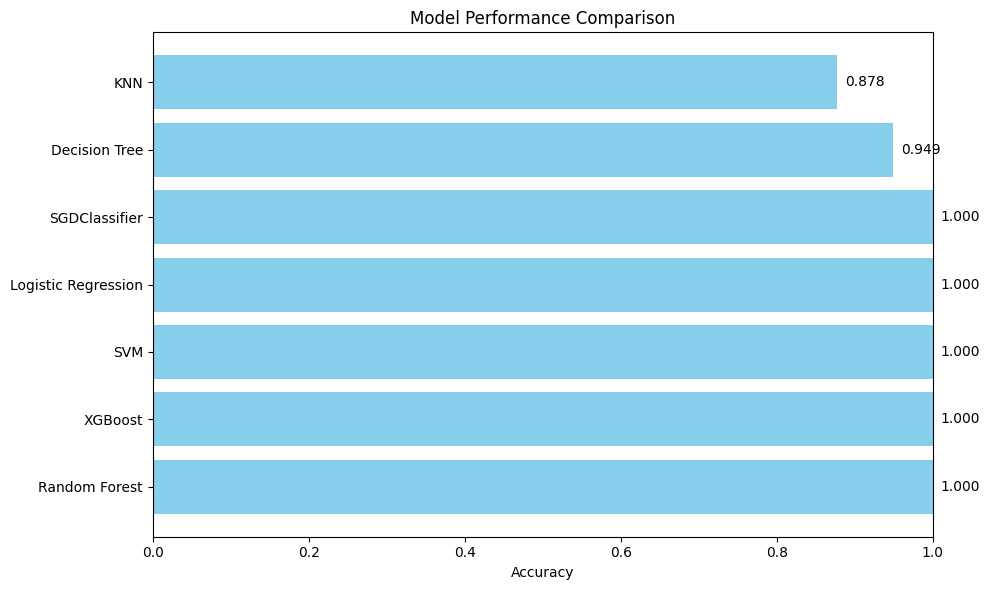


 Decision Tree Best Model Report
              precision    recall  f1-score   support

           0       0.99      0.94      0.96      4554
           1       0.88      0.97      0.92      1965

    accuracy                           0.95      6519
   macro avg       0.93      0.96      0.94      6519
weighted avg       0.95      0.95      0.95      6519



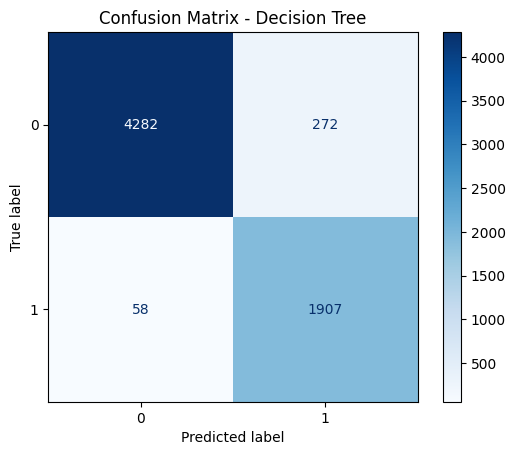


 Random Forest Best Model Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4554
           1       1.00      1.00      1.00      1965

    accuracy                           1.00      6519
   macro avg       1.00      1.00      1.00      6519
weighted avg       1.00      1.00      1.00      6519



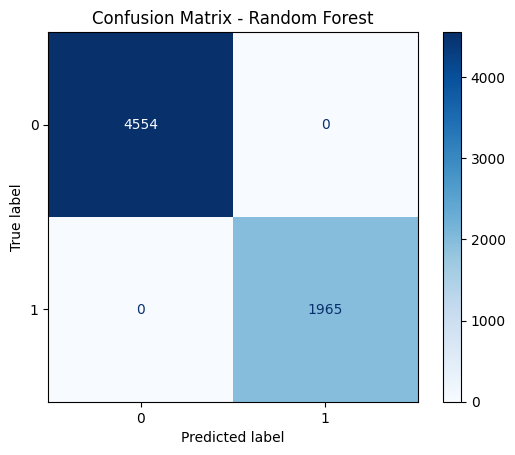


 KNN Best Model Report
              precision    recall  f1-score   support

           0       0.86      0.98      0.92      4554
           1       0.93      0.64      0.76      1965

    accuracy                           0.88      6519
   macro avg       0.90      0.81      0.84      6519
weighted avg       0.88      0.88      0.87      6519



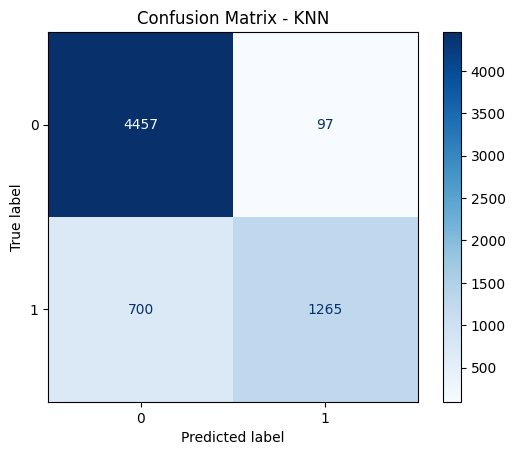


 SVM Best Model Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4554
           1       1.00      1.00      1.00      1965

    accuracy                           1.00      6519
   macro avg       1.00      1.00      1.00      6519
weighted avg       1.00      1.00      1.00      6519



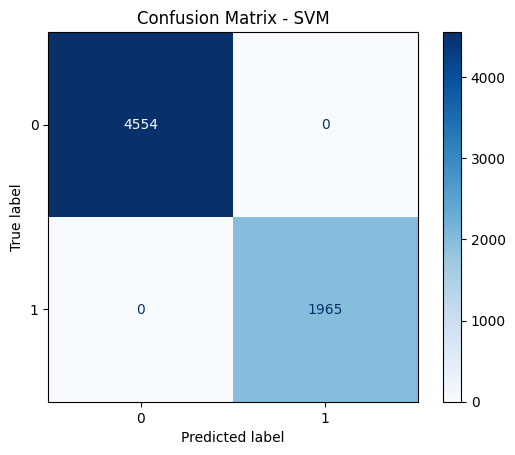


 XGBoost Best Model Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4554
           1       1.00      1.00      1.00      1965

    accuracy                           1.00      6519
   macro avg       1.00      1.00      1.00      6519
weighted avg       1.00      1.00      1.00      6519



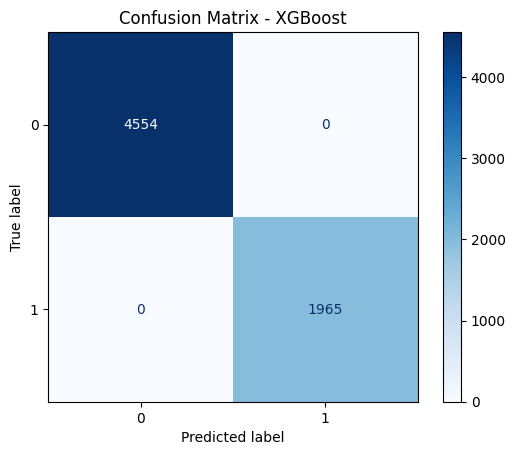


 Logistic Regression Best Model Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4554
           1       1.00      1.00      1.00      1965

    accuracy                           1.00      6519
   macro avg       1.00      1.00      1.00      6519
weighted avg       1.00      1.00      1.00      6519



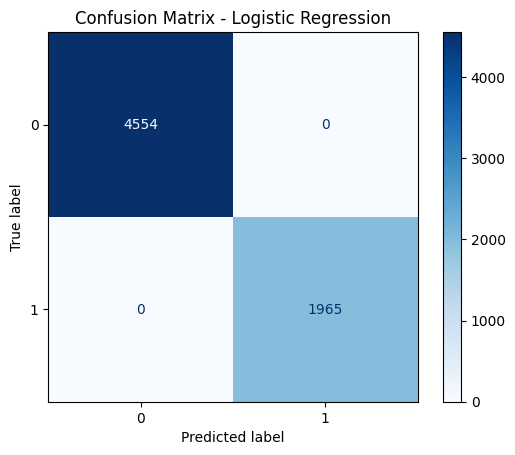


 SGDClassifier Best Model Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4554
           1       1.00      1.00      1.00      1965

    accuracy                           1.00      6519
   macro avg       1.00      1.00      1.00      6519
weighted avg       1.00      1.00      1.00      6519



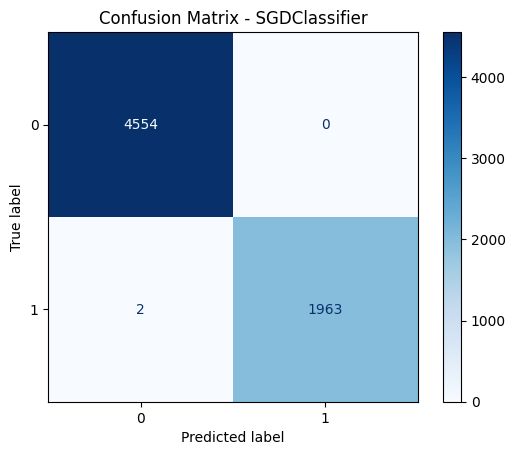

In [24]:
from util.model_tuning import auto_model_tuning
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neural_network import MLPClassifier

base_models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "KNN": Pipeline([
        ('scaler', StandardScaler(with_mean=False)),
        ('clf', KNeighborsClassifier())
    ]),
    "SVM": Pipeline([
        ('scaler', StandardScaler(with_mean=False)),
        ('clf', SVC(random_state=42))
    ]),
    "XGBoost": XGBClassifier(random_state=42),
    "Logistic Regression": Pipeline([
        ('scaler', StandardScaler(with_mean=False)),
        ('clf', LogisticRegression(max_iter=1000, random_state=42))
    ]),
    "SGDClassifier": Pipeline([
        ('scaler', StandardScaler(with_mean=False)),
        ('clf', SGDClassifier(random_state=42))
    ]),
    # "MLPClassifier": Pipeline([
    #     ('scaler', StandardScaler(with_mean=False)),
    #     ('clf', MLPClassifier(max_iter=1000, early_stopping=True, random_state=42))
    # ])
}

param_grids = {
    "Decision Tree": {
        "max_depth":range(1,5),
        "max_leaf_nodes": range(5, 21, 5),
        "min_samples_leaf": [2 ,5, 10],
        "max_features": range(1, 11, 2)},
    "Random Forest": {
        'n_estimators': [50],#, 100, 200, 300, 400],
        'max_depth':[10],#, 20, 30],
        "min_samples_leaf": [2],#, 5, 10],
        },
    "KNN": {
        'clf__n_neighbors': range(3,9),
        'clf__weights': ['uniform']},#, ['distance']},
    "SVM": {
        'clf__C': [0.001],#, 0.01, 0.1, 1, 10, 100],
        'clf__gamma': [0.01],#, 0.1, 1, 10, 100],
        'clf__kernel': ['linear']},#, ['rbf']},
    "XGBoost": {
        'n_estimators': [10, 30, 50],#, 100, 200, 400, 1000],
        'learning_rate' : [0.1, 0.01],#, 0.001],
        'max_depth': range(1,5)},
    "Logistic Regression": {
        'clf__C': [0.001, 0.01],#, 0.1, 1, 10, 100],  # 규제 강도
        'clf__penalty': ['l1', 'l2'],  # 규제 유형
        'clf__solver': ['saga']},
    "SGDClassifier": {
        'clf__loss': ['log_loss'],#, 'hinge'],  # log_loss=로지스틱, hinge=SVM
        'clf__alpha': [0.0001],#, 0.001, 0.01],  # 규제 계수
        'clf__learning_rate': ['constant'],#, 'adaptive'],
        'clf__eta0': [0.01],#, 0.1]},
    # "MLPClassifier": {
    #     'clf__hidden_layer_sizes': [(50,),],# (100,), (50, 30)],
    #     'clf__activation': ['relu', 'tanh'],
    #     'clf__alpha': [0.0001],#, 0.001],  # L2 규제 강도
    #     'clf__learning_rate_init': [0.001, 0.01],
    #     'clf__batch_size': [32]#, 64]
    }

}
# 함수 실행
results_df, best_models = auto_model_tuning(base_models, param_grids, X, y)

In [25]:
df = df_1

In [26]:
# # ###############################
# # #결측치 처리
# # #결측치 처리 컬럼: imd_band(범주형 -> 최빈값으로 처리), date_registration(수치형 -> mean으로 처리)
# # # date_unregisitration(9999값으로 채우기)

# # # 1. 결측치 직접 처리: date_unregistration → 9999
df["date_unregistration"] = df["date_unregistration"].fillna(9999)

# # 2. 인코딩 직접 처리

# # 1) highest_education 학력별로 부여
education_order = {
    "No Formal Quals": 0,
    "Lower Than A Level": 1,
    "A Level Or Equivalent": 2,
    "He Qualification": 3,
    "Post Graduate Qualification": 4
}

# 문자열 정리 후 replace 사용
df["highest_education"] = df["highest_education"].str.strip().str.title()
df["highest_education"] = df["highest_education"].replace(education_order)
df["highest_education"].value_counts()

# 2) age_band 중간 값으로 변경
age_map = {
    "0-35": 30,     # 또는 17.5, 20도 가능 (의도에 따라)
    "35-55": 45,
    "55<=": 60      # 55세 이상이므로 60 또는 65로 추정
}

df["age_band"] = df["age_band"].str.strip().str.title()
df["age_band"] = df["age_band"].replace(age_map)
df["age_band"].value_counts()
# # merged_df["age_band"] = merged_df["age_band"].map(age_map)

# # # # 3) 취약계층 서열화 
imd_order = {
    "0-10%": 1,
    "10-20": 2,
    "20-30%": 3,
    "30-40%": 4,
    "40-50%": 5,
    "50-60%": 6,
    "60-70%": 7,
    "70-80%": 8,
    "80-90%": 9,
    "90-100%": 10
}

df["imd_band"] = df["imd_band"].str.strip().str.title()
df["imd_band"] = df["imd_band"].replace(imd_order)
df["imd_band"].value_counts()
# merged_df["imd_band"] = merged_df["imd_band"].map(imd_order)

df.info()

# # # # 1. 원래 컬럼 순서 저장
original_columns = df.columns.tolist()

# 2. ColumnTransformer 설정
na_transformer = ColumnTransformer([
    ("category_imputer", SimpleImputer(strategy="most_frequent"), ['imd_band']),
    ("number_imputer", SimpleImputer(strategy="mean"), ['date_registration'])
], remainder="passthrough")

# 3. 처리 대상 및 passthrough 대상 정리
processed_columns = ['imd_band', 'date_registration']
passthrough_columns = [col for col in df.columns if col not in processed_columns]

# 4. fit_transform 적용
na_values_array = na_transformer.fit_transform(df)

# 5. DataFrame으로 변환 + 컬럼 순서 복원
na_values_df = pd.DataFrame(na_values_array, columns=processed_columns + passthrough_columns)
na_values_df = na_values_df[original_columns]  # 순서 복원!
na_values_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   code_module           32593 non-null  object 
 1   code_presentation     32593 non-null  object 
 2   gender                32593 non-null  object 
 3   region                32593 non-null  object 
 4   highest_education     32593 non-null  int64  
 5   imd_band              31482 non-null  float64
 6   age_band              32593 non-null  int64  
 7   num_of_prev_attempts  32593 non-null  int64  
 8   studied_credits       32593 non-null  int64  
 9   disability            32593 non-null  object 
 10  date_registration     32548 non-null  float64
 11  date_unregistration   32593 non-null  float64
 12  sum_click             32593 non-null  float64
 13  avg_score             32593 non-null  float64
 14  banked_ratio          32593 non-null  float64
 15  target_1           

,code_module,code_presentation,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,date_registration,date_unregistration,sum_click,avg_score,banked_ratio,target_1
0,AAA,2013J,M,East Anglian Region,3,10.0,60,0,240,N,-159.0,9999.0,934.0,82.0,0.0,0
1,AAA,2013J,F,Scotland,3,3.0,45,0,60,N,-53.0,9999.0,1435.0,66.4,0.0,0
2,AAA,2013J,F,North Western Region,2,4.0,45,0,60,Y,-92.0,12.0,281.0,0.0,0.0,1
3,AAA,2013J,F,South East Region,2,6.0,45,0,60,N,-52.0,9999.0,2158.0,76.0,0.0,0
4,AAA,2013J,F,West Midlands Region,1,6.0,30,0,60,N,-176.0,9999.0,1034.0,54.4,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32588,GGG,2014J,F,Wales,1,2.0,30,0,30,N,-4.0,9999.0,41.0,0.0,0.0,0
32589,GGG,2014J,F,East Anglian Region,1,5.0,45,0,30,N,-23.0,9999.0,893.0,88.111111,0.0,0
32590,GGG,2014J,F,South Region,2,3.0,30,0,30,Y,-129.0,9999.0,312.0,76.666667,0.0,0
32591,GGG,2014J,F,South East Region,1,10.0,45,0,30,N,-49.0,101.0,275.0,91.5,0.0,1


In [27]:
df

,code_module,code_presentation,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,date_registration,date_unregistration,sum_click,avg_score,banked_ratio,target_1
0,AAA,2013J,M,East Anglian Region,3,10.0,60,0,240,N,-159.0,9999.0,934.0,82.000000,0.0,0
1,AAA,2013J,F,Scotland,3,3.0,45,0,60,N,-53.0,9999.0,1435.0,66.400000,0.0,0
2,AAA,2013J,F,North Western Region,2,4.0,45,0,60,Y,-92.0,12.0,281.0,0.000000,0.0,1
3,AAA,2013J,F,South East Region,2,6.0,45,0,60,N,-52.0,9999.0,2158.0,76.000000,0.0,0
4,AAA,2013J,F,West Midlands Region,1,6.0,30,0,60,N,-176.0,9999.0,1034.0,54.400000,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32588,GGG,2014J,F,Wales,1,2.0,30,0,30,N,-4.0,9999.0,41.0,0.000000,0.0,0
32589,GGG,2014J,F,East Anglian Region,1,5.0,45,0,30,N,-23.0,9999.0,893.0,88.111111,0.0,0
32590,GGG,2014J,F,South Region,2,3.0,30,0,30,Y,-129.0,9999.0,312.0,76.666667,0.0,0
32591,GGG,2014J,F,South East Region,1,10.0,45,0,30,N,-49.0,101.0,275.0,91.500000,0.0,1


In [28]:
X = na_values_df.drop(columns='target_1').values
# X = X.astype('float32')
y = na_values_df['target_1'].values
# y = y.astype(int)
X.shape,  y.shape

((32593, 15), (32593,))

In [29]:
fe_transformer = ColumnTransformer([
    ("category_ohe", OneHotEncoder(), [0, 1, 2, 3, 4, 5, 6, 7, 9]),# feature의 index로 지정.   # index는 앞에 했던 배열로 적용해줘야함.
    ("number_scaler", StandardScaler(), [8, 10, 11, 12, 13, 14])    #feature Scaling은 연속형끼리 같은 방식을 사용 (standard or MinMax 중 택1)
])
### DataFrame이 입력일 경우 컬럼명이나 컬럼 index를 지정할 수 있다.
### ndarray가 입력일 경우 컬럼(feature) index를 지정.
new_merged_df = fe_transformer.fit_transform(X)
print(new_merged_df)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 488850 stored elements and shape (32593, 59)>
  Coords	Values
  (0, 0)	1.0
  (0, 8)	1.0
  (0, 12)	1.0
  (0, 13)	1.0
  (0, 29)	1.0
  (0, 40)	1.0
  (0, 43)	1.0
  (0, 44)	1.0
  (0, 51)	1.0
  (0, 53)	3.9015425811228486
  (0, 54)	-1.819956087383181
  (0, 55)	0.6687171152489204
  (0, 56)	-0.1661023462667018
  (0, 57)	0.7111682952048687
  (0, 58)	-0.15943823174950147
  (1, 0)	1.0
  (1, 8)	1.0
  (1, 11)	1.0
  (1, 19)	1.0
  (1, 29)	1.0
  (1, 33)	1.0
  (1, 42)	1.0
  (1, 44)	1.0
  (1, 51)	1.0
  (1, 53)	-0.4810830156421975
  :	:
  (32591, 40)	1.0
  (32591, 42)	1.0
  (32591, 44)	1.0
  (32591, 51)	1.0
  (32591, 53)	-1.2115206151030387
  (32591, 54)	0.41464682720239265
  (32591, 55)	-1.484106742765693
  (32591, 56)	-0.5554491366708715
  (32591, 57)	1.0144130896957386
  (32591, 58)	-0.15943823174950147
  (32592, 6)	1.0
  (32592, 10)	1.0
  (32592, 11)	1.0
  (32592, 25)	1.0
  (32592, 29)	1.0
  (32592, 36)	1.0
  (32592, 42)	1.0
  (32592, 44)	1

In [30]:
# 1. OneHotEncoder에서 실제 컬럼 이름 가져오기
ohe = fe_transformer.named_transformers_['category_ohe']
ohe_feature_names = ohe.get_feature_names_out(categorical_columns)

# 2. 수치형 컬럼 이름
numeric_feature_names = numeric_columns

# 3. 전체 컬럼 이름 합치기
all_feature_names = list(ohe_feature_names) + numeric_feature_names

df_sample = pd.DataFrame(new_merged_df[:5].toarray(), columns=all_feature_names)
df_sample

,code_module_AAA,code_module_BBB,code_module_CCC,code_module_DDD,code_module_EEE,code_module_FFF,code_module_GGG,code_presentation_2013B,code_presentation_2013J,code_presentation_2014B,...,num_of_prev_attempts_5,num_of_prev_attempts_6,disability_N,disability_Y,studied_credits,date_registration,date_unregistration,sum_click,avg_score,banked_ratio
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,3.901543,-1.819956,0.668717,-0.166102,0.711168,-0.159438
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,-0.481083,0.333389,0.668717,0.129896,0.213208,-0.159438
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,-0.481083,-0.458880,-1.503464,-0.551904,-1.906313,-0.159438
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,-0.481083,0.353703,0.668717,0.557055,0.519645,-0.159438
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,-0.481083,-2.165304,0.668717,-0.107021,-0.169838,-0.159438


In [32]:
X = new_merged_df
X = X.astype('float32')

y = na_values_df['target_1'].values
y = y.astype(int)

X.shape,  y.shape

((32593, 59), (32593,))


 >>> Tuning Decision Tree...
Fitting 5 folds for each of 240 candidates, totalling 1200 fits
- Complete:2.25461초

 >>> Tuning Random Forest...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
- Complete:3.47570초

 >>> Tuning KNN...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
- Complete:30.66718초

 >>> Tuning SVM...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
- Complete:12.52597초

 >>> Tuning XGBoost...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
- Complete:1.46183초

 >>> Tuning Logistic Regression...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
- Complete:3.24464초

 >>> Tuning SGDClassifier...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
- Complete:0.25534초

=== Final Comparison ===
              Model                                                                                          Best Params  Train Accuracy (CV)  Test Accuracy
      Random Forest                                         {'

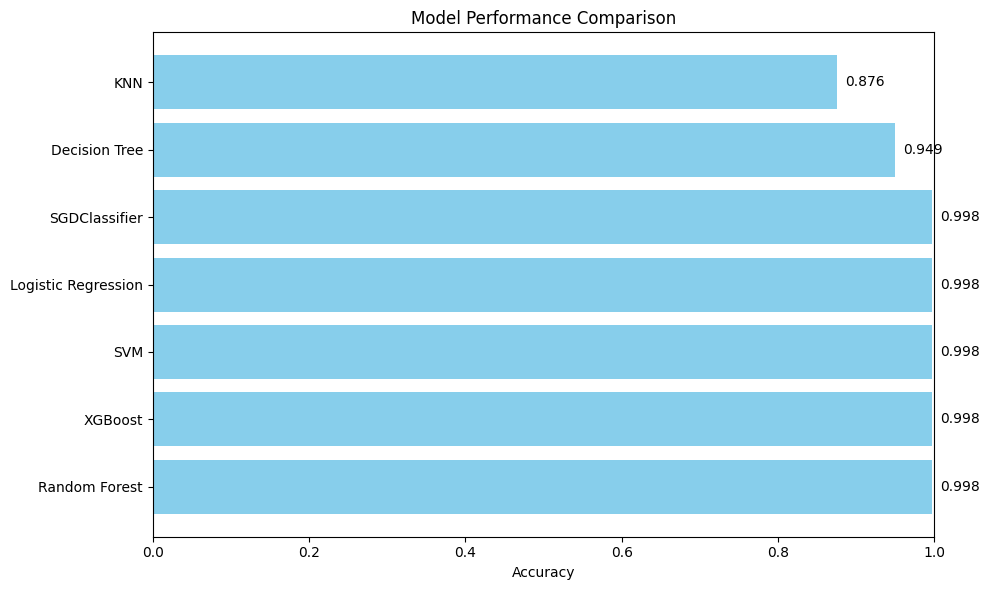


 Decision Tree Best Model Report
              precision    recall  f1-score   support

           0       0.99      0.94      0.96      4546
           1       0.88      0.97      0.92      1973

    accuracy                           0.95      6519
   macro avg       0.93      0.95      0.94      6519
weighted avg       0.95      0.95      0.95      6519



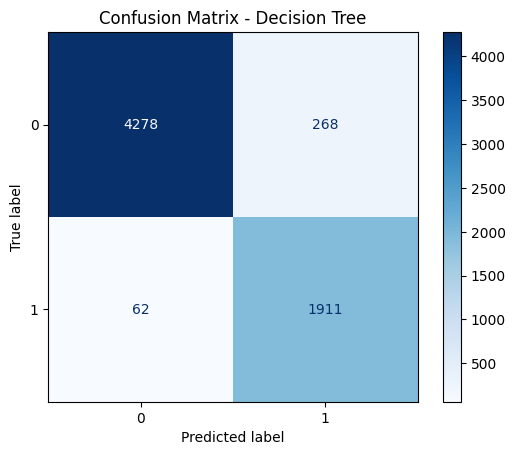


 Random Forest Best Model Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4546
           1       1.00      0.99      1.00      1973

    accuracy                           1.00      6519
   macro avg       1.00      1.00      1.00      6519
weighted avg       1.00      1.00      1.00      6519



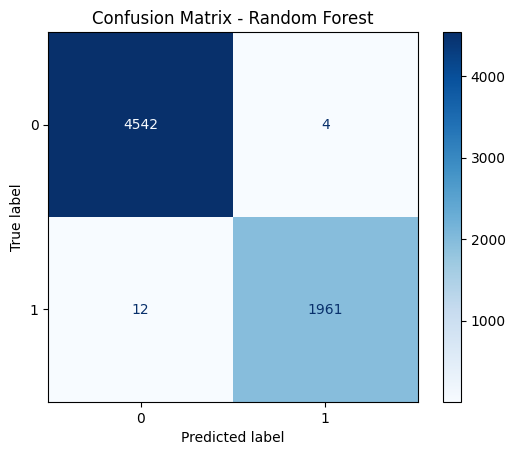


 KNN Best Model Report
              precision    recall  f1-score   support

           0       0.86      0.98      0.92      4546
           1       0.92      0.64      0.76      1973

    accuracy                           0.88      6519
   macro avg       0.89      0.81      0.84      6519
weighted avg       0.88      0.88      0.87      6519



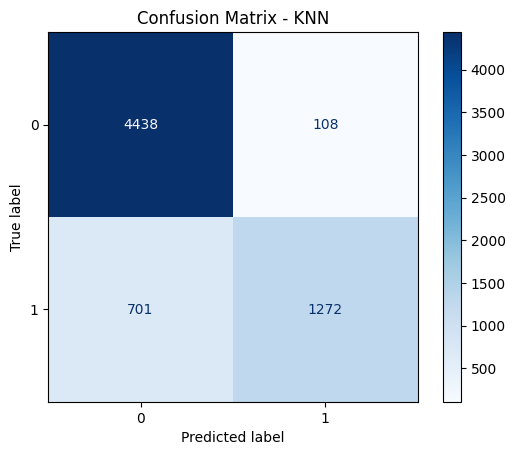


 SVM Best Model Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4546
           1       1.00      0.99      1.00      1973

    accuracy                           1.00      6519
   macro avg       1.00      1.00      1.00      6519
weighted avg       1.00      1.00      1.00      6519



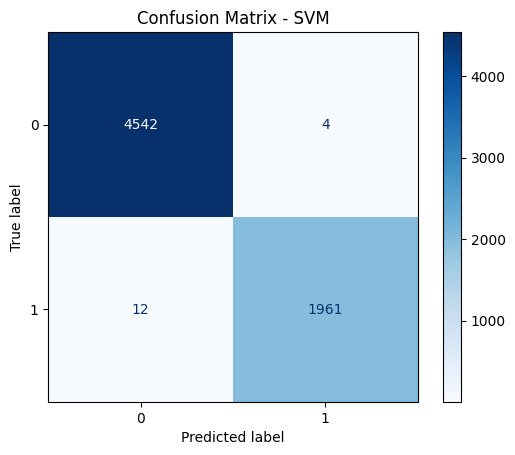


 XGBoost Best Model Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4546
           1       1.00      0.99      1.00      1973

    accuracy                           1.00      6519
   macro avg       1.00      1.00      1.00      6519
weighted avg       1.00      1.00      1.00      6519



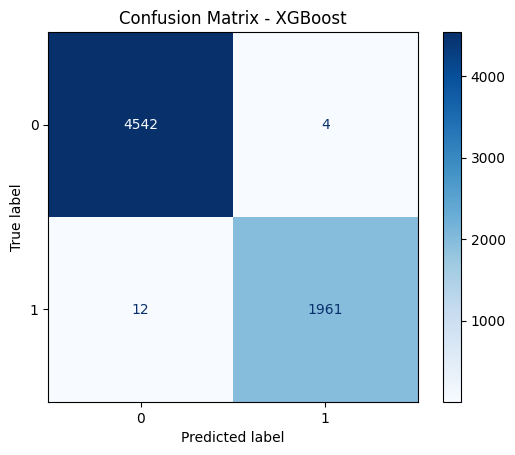


 Logistic Regression Best Model Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4546
           1       1.00      0.99      1.00      1973

    accuracy                           1.00      6519
   macro avg       1.00      1.00      1.00      6519
weighted avg       1.00      1.00      1.00      6519



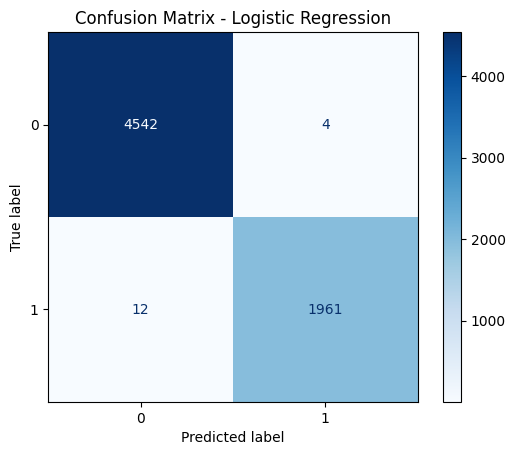


 SGDClassifier Best Model Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4546
           1       1.00      0.99      1.00      1973

    accuracy                           1.00      6519
   macro avg       1.00      1.00      1.00      6519
weighted avg       1.00      1.00      1.00      6519



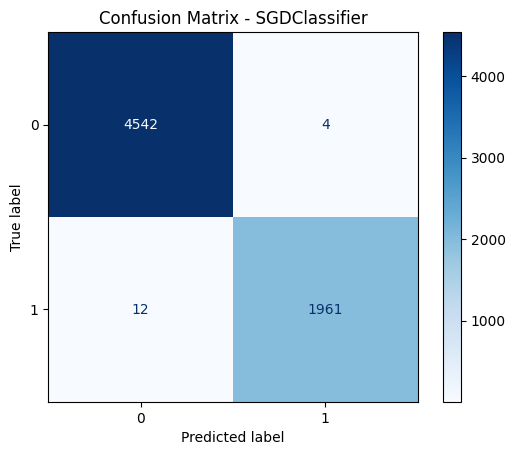

In [33]:
from util.model_tuning import auto_model_tuning
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neural_network import MLPClassifier

base_models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "KNN": Pipeline([
        ('scaler', StandardScaler(with_mean=False)),
        ('clf', KNeighborsClassifier())
    ]),
    "SVM": Pipeline([
        ('scaler', StandardScaler(with_mean=False)),
        ('clf', SVC(random_state=42))
    ]),
    "XGBoost": XGBClassifier(random_state=42),
    "Logistic Regression": Pipeline([
        ('scaler', StandardScaler(with_mean=False)),
        ('clf', LogisticRegression(max_iter=1000, random_state=42))
    ]),
    "SGDClassifier": Pipeline([
        ('scaler', StandardScaler(with_mean=False)),
        ('clf', SGDClassifier(random_state=42))
    ]),
    # "MLPClassifier": Pipeline([
    #     ('scaler', StandardScaler(with_mean=False)),
    #     ('clf', MLPClassifier(max_iter=1000, early_stopping=True, random_state=42))
    # ])
}

param_grids = {
    "Decision Tree": {
        "max_depth":range(1,5),
        "max_leaf_nodes": range(5, 21, 5),
        "min_samples_leaf": [2 ,5, 10],
        "max_features": range(1, 11, 2)},
    "Random Forest": {
        'n_estimators': [50],#, 100, 200, 300, 400],
        'max_depth':[10],#, 20, 30],
        "min_samples_leaf": [2],#, 5, 10],
        },
    "KNN": {
        'clf__n_neighbors': range(3,9),
        'clf__weights': ['uniform']},#, ['distance']},
    "SVM": {
        'clf__C': [0.001],#, 0.01, 0.1, 1, 10, 100],
        'clf__gamma': [0.01],#, 0.1, 1, 10, 100],
        'clf__kernel': ['linear']},#, ['rbf']},
    "XGBoost": {
        'n_estimators': [10, 30, 50],#, 100, 200, 400, 1000],
        'learning_rate' : [0.1, 0.01],#, 0.001],
        'max_depth': range(1,5)},
    "Logistic Regression": {
        'clf__C': [0.001, 0.01],#, 0.1, 1, 10, 100],  # 규제 강도
        'clf__penalty': ['l1', 'l2'],  # 규제 유형
        'clf__solver': ['saga']},
    "SGDClassifier": {
        'clf__loss': ['log_loss'],#, 'hinge'],  # log_loss=로지스틱, hinge=SVM
        'clf__alpha': [0.0001],#, 0.001, 0.01],  # 규제 계수
        'clf__learning_rate': ['constant'],#, 'adaptive'],
        'clf__eta0': [0.01],#, 0.1]},
    # "MLPClassifier": {
    #     'clf__hidden_layer_sizes': [(50,),],# (100,), (50, 30)],
    #     'clf__activation': ['relu', 'tanh'],
    #     'clf__alpha': [0.0001],#, 0.001],  # L2 규제 강도
    #     'clf__learning_rate_init': [0.001, 0.01],
    #     'clf__batch_size': [32]#, 64]
    }

}
# 함수 실행
results_df, best_models = auto_model_tuning(base_models, param_grids, X, y)

In [34]:
df = df_2

In [35]:
# # ###############################
# # #결측치 처리
# # #결측치 처리 컬럼: imd_band(범주형 -> 최빈값으로 처리), date_registration(수치형 -> mean으로 처리)
# # # date_unregisitration(9999값으로 채우기)

# # # 1. 결측치 직접 처리: date_unregistration → 9999
df["date_unregistration"] = df["date_unregistration"].fillna(9999)

# # 2. 인코딩 직접 처리

# # 1) highest_education 학력별로 부여
education_order = {
    "No Formal Quals": 0,
    "Lower Than A Level": 1,
    "A Level Or Equivalent": 2,
    "He Qualification": 3,
    "Post Graduate Qualification": 4
}

# 문자열 정리 후 replace 사용
df["highest_education"] = df["highest_education"].str.strip().str.title()
df["highest_education"] = df["highest_education"].replace(education_order)
df["highest_education"].value_counts()

# 2) age_band 중간 값으로 변경
age_map = {
    "0-35": 30,     # 또는 17.5, 20도 가능 (의도에 따라)
    "35-55": 45,
    "55<=": 60      # 55세 이상이므로 60 또는 65로 추정
}

df["age_band"] = df["age_band"].str.strip().str.title()
df["age_band"] = df["age_band"].replace(age_map)
df["age_band"].value_counts()
# # merged_df["age_band"] = merged_df["age_band"].map(age_map)

# # # # 3) 취약계층 서열화 
imd_order = {
    "0-10%": 1,
    "10-20": 2,
    "20-30%": 3,
    "30-40%": 4,
    "40-50%": 5,
    "50-60%": 6,
    "60-70%": 7,
    "70-80%": 8,
    "80-90%": 9,
    "90-100%": 10
}

df["imd_band"] = df["imd_band"].str.strip().str.title()
df["imd_band"] = df["imd_band"].replace(imd_order)
df["imd_band"].value_counts()
# merged_df["imd_band"] = merged_df["imd_band"].map(imd_order)

df.info()

# # # # 1. 원래 컬럼 순서 저장
original_columns = df.columns.tolist()

# 2. ColumnTransformer 설정
na_transformer = ColumnTransformer([
    ("category_imputer", SimpleImputer(strategy="most_frequent"), ['imd_band']),
    ("number_imputer", SimpleImputer(strategy="mean"), ['date_registration'])
], remainder="passthrough")

# 3. 처리 대상 및 passthrough 대상 정리
processed_columns = ['imd_band', 'date_registration']
passthrough_columns = [col for col in df.columns if col not in processed_columns]

# 4. fit_transform 적용
na_values_array = na_transformer.fit_transform(df)

# 5. DataFrame으로 변환 + 컬럼 순서 복원
na_values_df = pd.DataFrame(na_values_array, columns=processed_columns + passthrough_columns)
na_values_df = na_values_df[original_columns]  # 순서 복원!
na_values_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   code_module           32593 non-null  object 
 1   code_presentation     32593 non-null  object 
 2   gender                32593 non-null  object 
 3   region                32593 non-null  object 
 4   highest_education     32593 non-null  int64  
 5   imd_band              31482 non-null  float64
 6   age_band              32593 non-null  int64  
 7   num_of_prev_attempts  32593 non-null  int64  
 8   studied_credits       32593 non-null  int64  
 9   disability            32593 non-null  object 
 10  date_registration     32548 non-null  float64
 11  date_unregistration   32593 non-null  float64
 12  sum_click             32593 non-null  float64
 13  avg_score             32593 non-null  float64
 14  banked_ratio          32593 non-null  float64
 15  target_2           

,code_module,code_presentation,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,date_registration,date_unregistration,sum_click,avg_score,banked_ratio,target_2
0,AAA,2013J,M,East Anglian Region,3,10.0,60,0,240,N,-159.0,9999.0,934.0,82.0,0.0,0
1,AAA,2013J,F,Scotland,3,3.0,45,0,60,N,-53.0,9999.0,1435.0,66.4,0.0,0
2,AAA,2013J,F,North Western Region,2,4.0,45,0,60,Y,-92.0,12.0,281.0,0.0,0.0,1
3,AAA,2013J,F,South East Region,2,6.0,45,0,60,N,-52.0,9999.0,2158.0,76.0,0.0,0
4,AAA,2013J,F,West Midlands Region,1,6.0,30,0,60,N,-176.0,9999.0,1034.0,54.4,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32588,GGG,2014J,F,Wales,1,2.0,30,0,30,N,-4.0,9999.0,41.0,0.0,0.0,1
32589,GGG,2014J,F,East Anglian Region,1,5.0,45,0,30,N,-23.0,9999.0,893.0,88.111111,0.0,0
32590,GGG,2014J,F,South Region,2,3.0,30,0,30,Y,-129.0,9999.0,312.0,76.666667,0.0,0
32591,GGG,2014J,F,South East Region,1,10.0,45,0,30,N,-49.0,101.0,275.0,91.5,0.0,1


In [36]:
df

,code_module,code_presentation,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,date_registration,date_unregistration,sum_click,avg_score,banked_ratio,target_2
0,AAA,2013J,M,East Anglian Region,3,10.0,60,0,240,N,-159.0,9999.0,934.0,82.000000,0.0,0
1,AAA,2013J,F,Scotland,3,3.0,45,0,60,N,-53.0,9999.0,1435.0,66.400000,0.0,0
2,AAA,2013J,F,North Western Region,2,4.0,45,0,60,Y,-92.0,12.0,281.0,0.000000,0.0,1
3,AAA,2013J,F,South East Region,2,6.0,45,0,60,N,-52.0,9999.0,2158.0,76.000000,0.0,0
4,AAA,2013J,F,West Midlands Region,1,6.0,30,0,60,N,-176.0,9999.0,1034.0,54.400000,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32588,GGG,2014J,F,Wales,1,2.0,30,0,30,N,-4.0,9999.0,41.0,0.000000,0.0,1
32589,GGG,2014J,F,East Anglian Region,1,5.0,45,0,30,N,-23.0,9999.0,893.0,88.111111,0.0,0
32590,GGG,2014J,F,South Region,2,3.0,30,0,30,Y,-129.0,9999.0,312.0,76.666667,0.0,0
32591,GGG,2014J,F,South East Region,1,10.0,45,0,30,N,-49.0,101.0,275.0,91.500000,0.0,1


In [37]:
X = na_values_df.drop(columns='target_2').values
# X = X.astype('float32')
y = na_values_df['target_2'].values
# y = y.astype(int)
X.shape,  y.shape

((32593, 15), (32593,))

In [38]:
fe_transformer = ColumnTransformer([
    ("category_ohe", OneHotEncoder(), [0, 1, 2, 3, 4, 5, 6, 7, 9]),# feature의 index로 지정.   # index는 앞에 했던 배열로 적용해줘야함.
    ("number_scaler", StandardScaler(), [8, 10, 11, 12, 13, 14])    #feature Scaling은 연속형끼리 같은 방식을 사용 (standard or MinMax 중 택1)
])
### DataFrame이 입력일 경우 컬럼명이나 컬럼 index를 지정할 수 있다.
### ndarray가 입력일 경우 컬럼(feature) index를 지정.
new_merged_df = fe_transformer.fit_transform(X)
print(new_merged_df)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 488850 stored elements and shape (32593, 59)>
  Coords	Values
  (0, 0)	1.0
  (0, 8)	1.0
  (0, 12)	1.0
  (0, 13)	1.0
  (0, 29)	1.0
  (0, 40)	1.0
  (0, 43)	1.0
  (0, 44)	1.0
  (0, 51)	1.0
  (0, 53)	3.9015425811228486
  (0, 54)	-1.819956087383181
  (0, 55)	0.6687171152489204
  (0, 56)	-0.1661023462667018
  (0, 57)	0.7111682952048687
  (0, 58)	-0.15943823174950147
  (1, 0)	1.0
  (1, 8)	1.0
  (1, 11)	1.0
  (1, 19)	1.0
  (1, 29)	1.0
  (1, 33)	1.0
  (1, 42)	1.0
  (1, 44)	1.0
  (1, 51)	1.0
  (1, 53)	-0.4810830156421975
  :	:
  (32591, 40)	1.0
  (32591, 42)	1.0
  (32591, 44)	1.0
  (32591, 51)	1.0
  (32591, 53)	-1.2115206151030387
  (32591, 54)	0.41464682720239265
  (32591, 55)	-1.484106742765693
  (32591, 56)	-0.5554491366708715
  (32591, 57)	1.0144130896957386
  (32591, 58)	-0.15943823174950147
  (32592, 6)	1.0
  (32592, 10)	1.0
  (32592, 11)	1.0
  (32592, 25)	1.0
  (32592, 29)	1.0
  (32592, 36)	1.0
  (32592, 42)	1.0
  (32592, 44)	1

In [39]:
# 1. OneHotEncoder에서 실제 컬럼 이름 가져오기
ohe = fe_transformer.named_transformers_['category_ohe']
ohe_feature_names = ohe.get_feature_names_out(categorical_columns)

# 2. 수치형 컬럼 이름
numeric_feature_names = numeric_columns

# 3. 전체 컬럼 이름 합치기
all_feature_names = list(ohe_feature_names) + numeric_feature_names

df_sample = pd.DataFrame(new_merged_df[:5].toarray(), columns=all_feature_names)
df_sample

,code_module_AAA,code_module_BBB,code_module_CCC,code_module_DDD,code_module_EEE,code_module_FFF,code_module_GGG,code_presentation_2013B,code_presentation_2013J,code_presentation_2014B,...,num_of_prev_attempts_5,num_of_prev_attempts_6,disability_N,disability_Y,studied_credits,date_registration,date_unregistration,sum_click,avg_score,banked_ratio
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,3.901543,-1.819956,0.668717,-0.166102,0.711168,-0.159438
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,-0.481083,0.333389,0.668717,0.129896,0.213208,-0.159438
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,-0.481083,-0.458880,-1.503464,-0.551904,-1.906313,-0.159438
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,-0.481083,0.353703,0.668717,0.557055,0.519645,-0.159438
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,-0.481083,-2.165304,0.668717,-0.107021,-0.169838,-0.159438


In [40]:
X = new_merged_df
X = X.astype('float32')

y = na_values_df['target_2'].values
y = y.astype(int)

X.shape,  y.shape

((32593, 59), (32593,))


 >>> Tuning Decision Tree...
Fitting 5 folds for each of 240 candidates, totalling 1200 fits
- Complete:2.28833초

 >>> Tuning Random Forest...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
- Complete:4.30471초

 >>> Tuning KNN...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
- Complete:29.82018초

 >>> Tuning SVM...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
- Complete:43.42140초

 >>> Tuning XGBoost...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
- Complete:1.53214초

 >>> Tuning Logistic Regression...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
- Complete:3.31872초

 >>> Tuning SGDClassifier...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
- Complete:0.24381초

=== Final Comparison ===
              Model                                                                                          Best Params  Train Accuracy (CV)  Test Accuracy
            XGBoost                                           

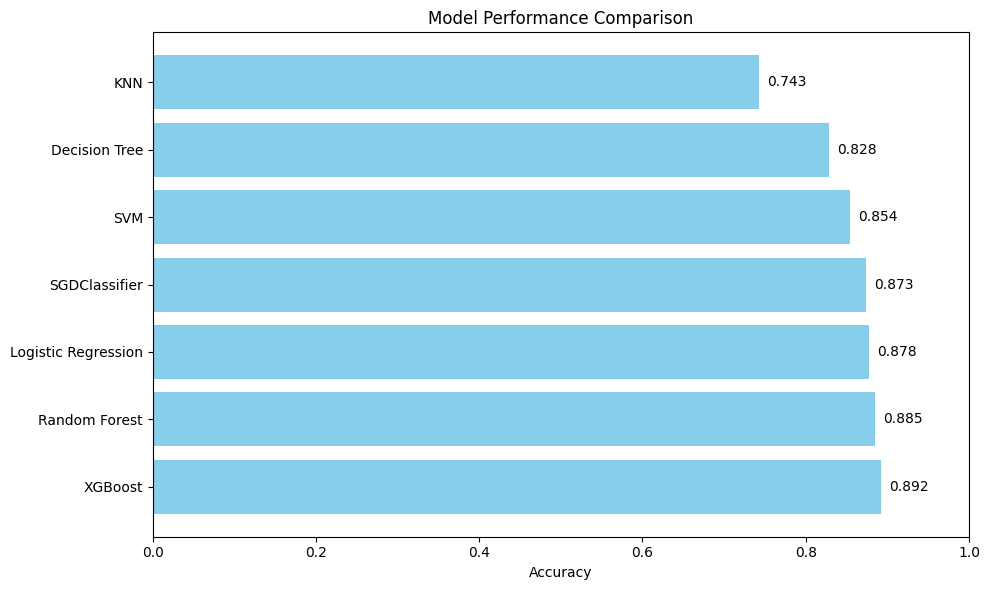


 Decision Tree Best Model Report
              precision    recall  f1-score   support

           0       0.78      0.88      0.83      3051
           1       0.88      0.78      0.83      3468

    accuracy                           0.83      6519
   macro avg       0.83      0.83      0.83      6519
weighted avg       0.83      0.83      0.83      6519



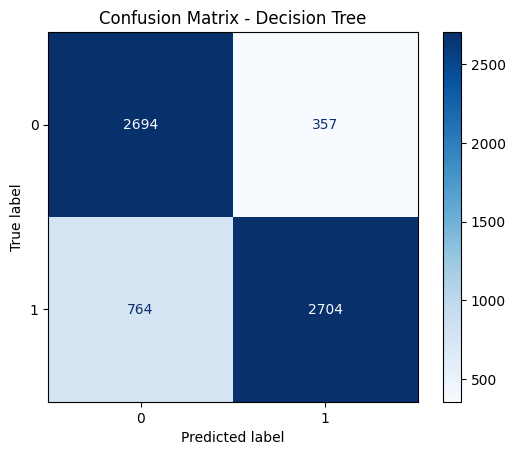


 Random Forest Best Model Report
              precision    recall  f1-score   support

           0       0.83      0.94      0.88      3051
           1       0.94      0.83      0.88      3468

    accuracy                           0.88      6519
   macro avg       0.89      0.89      0.88      6519
weighted avg       0.89      0.88      0.88      6519



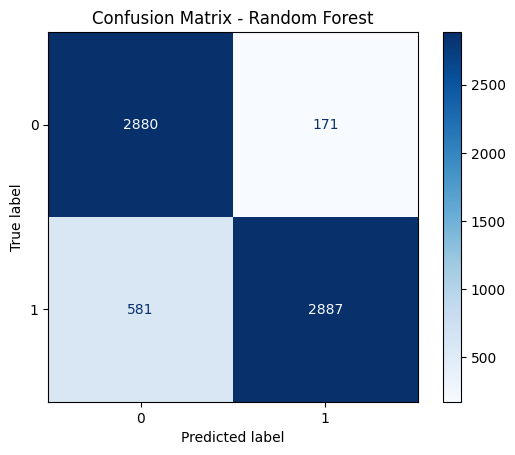


 KNN Best Model Report
              precision    recall  f1-score   support

           0       0.70      0.80      0.74      3051
           1       0.80      0.70      0.74      3468

    accuracy                           0.74      6519
   macro avg       0.75      0.75      0.74      6519
weighted avg       0.75      0.74      0.74      6519



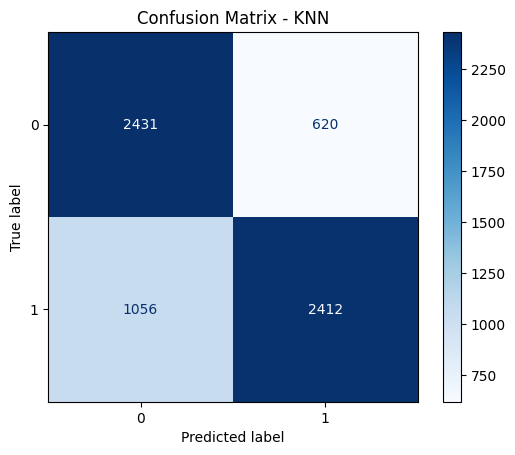


 SVM Best Model Report
              precision    recall  f1-score   support

           0       0.77      0.98      0.86      3051
           1       0.97      0.75      0.85      3468

    accuracy                           0.85      6519
   macro avg       0.87      0.86      0.85      6519
weighted avg       0.88      0.85      0.85      6519



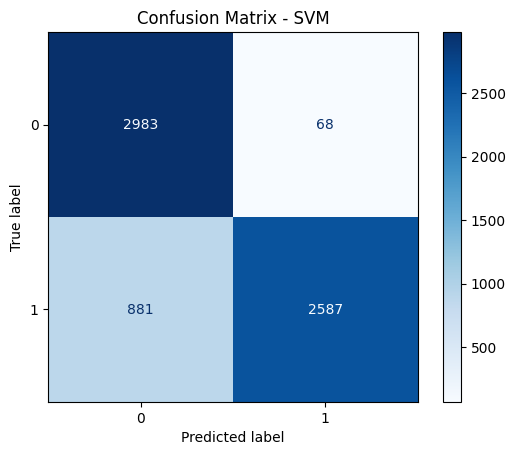


 XGBoost Best Model Report
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      3051
           1       0.95      0.84      0.89      3468

    accuracy                           0.89      6519
   macro avg       0.90      0.90      0.89      6519
weighted avg       0.90      0.89      0.89      6519



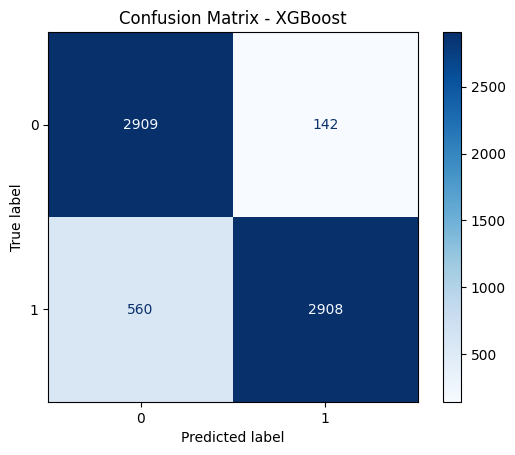


 Logistic Regression Best Model Report
              precision    recall  f1-score   support

           0       0.83      0.93      0.88      3051
           1       0.93      0.83      0.88      3468

    accuracy                           0.88      6519
   macro avg       0.88      0.88      0.88      6519
weighted avg       0.88      0.88      0.88      6519



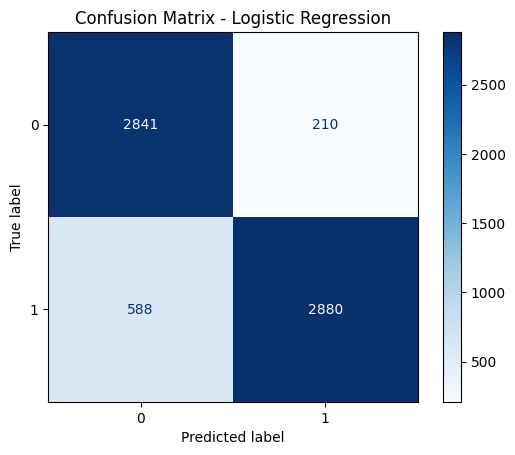


 SGDClassifier Best Model Report
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      3051
           1       0.91      0.84      0.88      3468

    accuracy                           0.87      6519
   macro avg       0.87      0.88      0.87      6519
weighted avg       0.88      0.87      0.87      6519



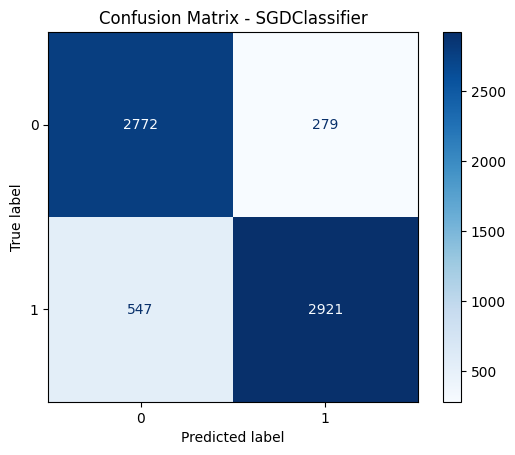

In [41]:
from util.model_tuning import auto_model_tuning
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neural_network import MLPClassifier

base_models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "KNN": Pipeline([
        ('scaler', StandardScaler(with_mean=False)),
        ('clf', KNeighborsClassifier())
    ]),
    "SVM": Pipeline([
        ('scaler', StandardScaler(with_mean=False)),
        ('clf', SVC(random_state=42))
    ]),
    "XGBoost": XGBClassifier(random_state=42),
    "Logistic Regression": Pipeline([
        ('scaler', StandardScaler(with_mean=False)),
        ('clf', LogisticRegression(max_iter=1000, random_state=42))
    ]),
    "SGDClassifier": Pipeline([
        ('scaler', StandardScaler(with_mean=False)),
        ('clf', SGDClassifier(random_state=42))
    ]),
    # "MLPClassifier": Pipeline([
    #     ('scaler', StandardScaler(with_mean=False)),
    #     ('clf', MLPClassifier(max_iter=1000, early_stopping=True, random_state=42))
    # ])
}

param_grids = {
    "Decision Tree": {
        "max_depth":range(1,5),
        "max_leaf_nodes": range(5, 21, 5),
        "min_samples_leaf": [2 ,5, 10],
        "max_features": range(1, 11, 2)},
    "Random Forest": {
        'n_estimators': [50],#, 100, 200, 300, 400],
        'max_depth':[10],#, 20, 30],
        "min_samples_leaf": [2],#, 5, 10],
        },
    "KNN": {
        'clf__n_neighbors': range(3,9),
        'clf__weights': ['uniform']},#, ['distance']},
    "SVM": {
        'clf__C': [0.001],#, 0.01, 0.1, 1, 10, 100],
        'clf__gamma': [0.01],#, 0.1, 1, 10, 100],
        'clf__kernel': ['linear']},#, ['rbf']},
    "XGBoost": {
        'n_estimators': [10, 30, 50],#, 100, 200, 400, 1000],
        'learning_rate' : [0.1, 0.01],#, 0.001],
        'max_depth': range(1,5)},
    "Logistic Regression": {
        'clf__C': [0.001, 0.01],#, 0.1, 1, 10, 100],  # 규제 강도
        'clf__penalty': ['l1', 'l2'],  # 규제 유형
        'clf__solver': ['saga']},
    "SGDClassifier": {
        'clf__loss': ['log_loss'],#, 'hinge'],  # log_loss=로지스틱, hinge=SVM
        'clf__alpha': [0.0001],#, 0.001, 0.01],  # 규제 계수
        'clf__learning_rate': ['constant'],#, 'adaptive'],
        'clf__eta0': [0.01],#, 0.1]},
    # "MLPClassifier": {
    #     'clf__hidden_layer_sizes': [(50,),],# (100,), (50, 30)],
    #     'clf__activation': ['relu', 'tanh'],
    #     'clf__alpha': [0.0001],#, 0.001],  # L2 규제 강도
    #     'clf__learning_rate_init': [0.001, 0.01],
    #     'clf__batch_size': [32]#, 64]
    }

}
# 함수 실행
results_df, best_models = auto_model_tuning(base_models, param_grids, X, y)

In [ ]:
asdasdasd

NameError: name 'asdasdasd' is not defined

In [ ]:
merged_df = pd.read_csv("../data/merged_dataset_ver1.1.1.csv")
merged_df

In [ ]:
categorical_columns = ['code_module','code_presentation','gender','region','highest_education', 'imd_band', 'age_band', 'num_of_prev_attempts', 'disability', 'is_dropout']
numeric_columns = ['studied_credits', 'date_registration', 'date_unregistration', 'sum_click', 'avg_score', 'banked_ratio']
target = "target"  # index =17

categorical_columns_index = [0, 1, 3, 4, 5, 6, 7, 8, 10, 16]
numeric_columns_index = [9,11,12,13,14,15]

In [ ]:
# ###############################
# #결측치 처리
# #결측치 처리 컬럼: imd_band(범주형 -> 최빈값으로 처리), date_registration(수치형 -> mean으로 처리)
# # date_unregisitration(9999값으로 채우기)

# # 1. 결측치 직접 처리: date_unregistration → 9999
# merged_df["date_unregistration"] = merged_df["date_unregistration"].fillna(9999)

# # 1. 원래 컬럼 순서 저장
# original_columns = merged_df.columns.tolist()

# # 2. ColumnTransformer 설정
# na_transformer = ColumnTransformer([
#     ("category_imputer", SimpleImputer(strategy="most_frequent"), ['imd_band']),
#     ("number_imputer", SimpleImputer(strategy="mean"), ['date_registration'])
# ], remainder="passthrough")

# # 3. 처리 대상 및 passthrough 대상 정리
# processed_columns = ['imd_band', 'date_registration']
# passthrough_columns = [col for col in merged_df.columns if col not in processed_columns]

# # 4. fit_transform 적용
# na_values_array = na_transformer.fit_transform(merged_df)

# # 5. DataFrame으로 변환 + 컬럼 순서 복원
# na_values_df = pd.DataFrame(na_values_array, columns=processed_columns + passthrough_columns)
# na_values_df = na_values_df[original_columns]  # 순서 복원!

In [ ]:
# # ###############################
# # #결측치 처리
# # #결측치 처리 컬럼: imd_band(범주형 -> 최빈값으로 처리), date_registration(수치형 -> mean으로 처리)
# # # date_unregisitration(9999값으로 채우기)

# # # 1. 결측치 직접 처리: date_unregistration → 9999
merged_df["date_unregistration"] = merged_df["date_unregistration"].fillna(9999)

# # 2. 인코딩 직접 처리

# # 1) highest_education 학력별로 부여
education_order = {
    "No Formal Quals": 0,
    "Lower Than A Level": 1,
    "A Level Or Equivalent": 2,
    "He Qualification": 3,
    "Post Graduate Qualification": 4
}

# 문자열 정리 후 replace 사용
merged_df["highest_education"] = merged_df["highest_education"].str.strip().str.title()
merged_df["highest_education"] = merged_df["highest_education"].replace(education_order)
merged_df["highest_education"].value_counts()

# 2) age_band 중간 값으로 변경
age_map = {
    "0-35": 30,     # 또는 17.5, 20도 가능 (의도에 따라)
    "35-55": 45,
    "55<=": 60      # 55세 이상이므로 60 또는 65로 추정
}

merged_df["age_band"] = merged_df["age_band"].str.strip().str.title()
merged_df["age_band"] = merged_df["age_band"].replace(age_map)
merged_df["age_band"].value_counts()
# # merged_df["age_band"] = merged_df["age_band"].map(age_map)

# # # # 3) 취약계층 서열화 
imd_order = {
    "0-10%": 1,
    "10-20": 2,
    "20-30%": 3,
    "30-40%": 4,
    "40-50%": 5,
    "50-60%": 6,
    "60-70%": 7,
    "70-80%": 8,
    "80-90%": 9,
    "90-100%": 10
}

merged_df["imd_band"] = merged_df["imd_band"].str.strip().str.title()
merged_df["imd_band"] = merged_df["imd_band"].replace(imd_order)
merged_df["imd_band"].value_counts()
# merged_df["imd_band"] = merged_df["imd_band"].map(imd_order)

merged_df.info()

# # # # 1. 원래 컬럼 순서 저장
original_columns = merged_df.columns.tolist()

# 2. ColumnTransformer 설정
na_transformer = ColumnTransformer([
    ("category_imputer", SimpleImputer(strategy="most_frequent"), ['imd_band']),
    ("number_imputer", SimpleImputer(strategy="mean"), ['date_registration'])
], remainder="passthrough")

# 3. 처리 대상 및 passthrough 대상 정리
processed_columns = ['imd_band', 'date_registration']
passthrough_columns = [col for col in merged_df.columns if col not in processed_columns]

# 4. fit_transform 적용
na_values_array = na_transformer.fit_transform(merged_df)

# 5. DataFrame으로 변환 + 컬럼 순서 복원
na_values_df = pd.DataFrame(na_values_array, columns=processed_columns + passthrough_columns)
na_values_df = na_values_df[original_columns]  # 순서 복원!
na_values_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32545 entries, 0 to 32544
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   code_module           32545 non-null  object 
 1   code_presentation     32545 non-null  object 
 2   id_student            32545 non-null  int64  
 3   gender                32545 non-null  object 
 4   region                32545 non-null  object 
 5   highest_education     32545 non-null  int64  
 6   imd_band              31434 non-null  float64
 7   age_band              32545 non-null  int64  
 8   num_of_prev_attempts  32545 non-null  int64  
 9   studied_credits       32545 non-null  int64  
 10  disability            32545 non-null  object 
 11  date_registration     32539 non-null  float64
 12  date_unregistration   32545 non-null  float64
 13  sum_click             32545 non-null  float64
 14  avg_score             32545 non-null  float64
 15  banked_ratio       

C:\Users\kimzi\AppData\Local\Temp\ipykernel_25344\1777138276.py:22: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_df["highest_education"] = merged_df["highest_education"].replace(education_order)
C:\Users\kimzi\AppData\Local\Temp\ipykernel_25344\1777138276.py:33: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_df["age_band"] = merged_df["age_band"].replace(age_map)
C:\Users\kimzi\AppData\Local\Temp\ipykernel_25344\1777138276.py:52: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a 

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,date_registration,date_unregistration,sum_click,avg_score,banked_ratio,is_dropout,target
0,AAA,2013J,11391,M,East Anglian Region,3,10.0,60,0,240,N,-159.0,9999.0,934.0,82.0,0.0,0,0
1,AAA,2013J,28400,F,Scotland,3,3.0,45,0,60,N,-53.0,9999.0,1435.0,66.4,0.0,0,0
2,AAA,2013J,30268,F,North Western Region,2,4.0,45,0,60,Y,-92.0,12.0,281.0,0.0,0.0,1,1
3,AAA,2013J,31604,F,South East Region,2,6.0,45,0,60,N,-52.0,9999.0,2158.0,76.0,0.0,0,0
4,AAA,2013J,32885,F,West Midlands Region,1,6.0,30,0,60,N,-176.0,9999.0,1034.0,54.4,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32540,GGG,2014J,2640965,F,Wales,1,2.0,30,0,30,N,-4.0,9999.0,41.0,0.0,0.0,0,1
32541,GGG,2014J,2645731,F,East Anglian Region,1,5.0,45,0,30,N,-23.0,9999.0,893.0,88.111111,0.0,0,0
32542,GGG,2014J,2648187,F,South Region,2,3.0,30,0,30,Y,-129.0,9999.0,312.0,76.666667,0.0,0,0
32543,GGG,2014J,2679821,F,South East Region,1,10.0,45,0,30,N,-49.0,101.0,275.0,91.5,0.0,1,1


In [ ]:
X = na_values_df.drop(columns='target').values
# X = X.astype('float32')
y = na_values_df['target'].values
# y = y.astype(int)
X.shape,  y.shape

((32545, 17), (32545,))

In [ ]:
fe_transformer = ColumnTransformer([
    ("category_ohe", OneHotEncoder(), [0, 1, 3, 4, 5, 6, 7, 8, 10,16]),# feature의 index로 지정.   # index는 앞에 했던 배열로 적용해줘야함.
    ("number_scaler", StandardScaler(), [9,11,12,13,14,15])    #feature Scaling은 연속형끼리 같은 방식을 사용 (standard or MinMax 중 택1)
])
### DataFrame이 입력일 경우 컬럼명이나 컬럼 index를 지정할 수 있다.
### ndarray가 입력일 경우 컬럼(feature) index를 지정.
new_merged_df = fe_transformer.fit_transform(X)
print(new_merged_df)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 520714 stored elements and shape (32545, 61)>
  Coords	Values
  (0, 0)	1.0
  (0, 8)	1.0
  (0, 12)	1.0
  (0, 13)	1.0
  (0, 29)	1.0
  (0, 40)	1.0
  (0, 43)	1.0
  (0, 44)	1.0
  (0, 51)	1.0
  (0, 53)	1.0
  (0, 55)	3.905125197007625
  (0, 56)	-1.8185928989610989
  (0, 57)	0.6671221427396934
  (0, 58)	-0.1670317117402033
  (0, 59)	0.7100890620793591
  (0, 60)	-0.15938465469985008
  (1, 0)	1.0
  (1, 8)	1.0
  (1, 11)	1.0
  (1, 19)	1.0
  (1, 29)	1.0
  (1, 33)	1.0
  (1, 42)	1.0
  (1, 44)	1.0
  (1, 51)	1.0
  :	:
  (32543, 44)	1.0
  (32543, 51)	1.0
  (32543, 54)	1.0
  (32543, 55)	-1.211159957215567
  (32543, 56)	0.4144516877944941
  (32543, 57)	-1.487791864498921
  (32543, 58)	-0.5562260670917427
  (32543, 59)	1.0137563256706723
  (32543, 60)	-0.15938465469985008
  (32544, 6)	1.0
  (32544, 10)	1.0
  (32544, 11)	1.0
  (32544, 25)	1.0
  (32544, 29)	1.0
  (32544, 36)	1.0
  (32544, 42)	1.0
  (32544, 44)	1.0
  (32544, 51)	1.0
  (32544, 53)	1

In [ ]:
new_merged_df

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 520714 stored elements and shape (32545, 61)>

In [ ]:
# 1. OneHotEncoder에서 실제 컬럼 이름 가져오기
ohe = fe_transformer.named_transformers_['category_ohe']
ohe_feature_names = ohe.get_feature_names_out(categorical_columns)

# 2. 수치형 컬럼 이름
numeric_feature_names = numeric_columns

# 3. 전체 컬럼 이름 합치기
all_feature_names = list(ohe_feature_names) + numeric_feature_names

In [ ]:
df_sample = pd.DataFrame(new_merged_df[:5].toarray(), columns=all_feature_names)
df_sample

,code_module_AAA,code_module_BBB,code_module_CCC,code_module_DDD,code_module_EEE,code_module_FFF,code_module_GGG,code_presentation_2013B,code_presentation_2013J,code_presentation_2014B,...,disability_N,disability_Y,is_dropout_0,is_dropout_1,studied_credits,date_registration,date_unregistration,sum_click,avg_score,banked_ratio
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,3.905125,-1.818593,0.667122,-0.167032,0.710089,-0.159385
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,-0.480262,0.333250,0.667122,0.128850,0.211435,-0.159385
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,-0.480262,-0.458466,-1.507168,-0.552683,-1.911039,-0.159385
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,-0.480262,0.353550,0.667122,0.555842,0.518299,-0.159385
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,-0.480262,-2.163700,0.667122,-0.107973,-0.172144,-0.159385


In [ ]:
new_merged_df

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 520714 stored elements and shape (32545, 61)>

In [ ]:

X = new_merged_df
X = X.astype('float32')

y = na_values_df['target'].values
y = y.astype(int)

X.shape,  y.shape

((32545, 61), (32545,))


 >>> Tuning Decision Tree...
Fitting 5 folds for each of 240 candidates, totalling 1200 fits
- Complete:6.40256초

 >>> Tuning Random Forest...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
- Complete:3.93889초

 >>> Tuning KNN...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
- Complete:33.43148초

 >>> Tuning XGBoost...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
- Complete:0.51736초

 >>> Tuning Logistic Regression...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
- Complete:0.96310초

 >>> Tuning SGDClassifier...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
- Complete:0.23688초

=== Final Comparison ===
              Model                                                                                          Best Params  Train Accuracy (CV)  Test Accuracy
      Random Forest                                         {'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 50}             0.884352       0.887079
      SG

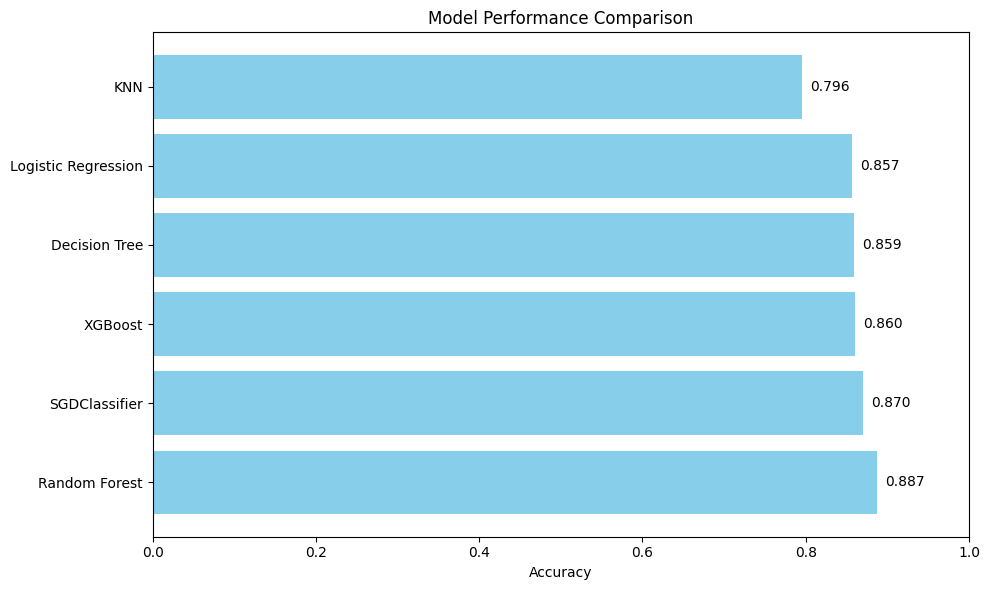


 Decision Tree Best Model Report
              precision    recall  f1-score   support

           0       0.80      0.92      0.86      3056
           1       0.92      0.80      0.86      3453

    accuracy                           0.86      6509
   macro avg       0.86      0.86      0.86      6509
weighted avg       0.87      0.86      0.86      6509



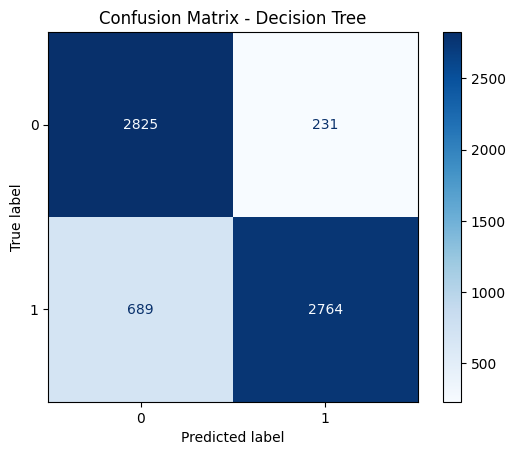


 Random Forest Best Model Report
              precision    recall  f1-score   support

           0       0.83      0.96      0.89      3056
           1       0.95      0.83      0.89      3453

    accuracy                           0.89      6509
   macro avg       0.89      0.89      0.89      6509
weighted avg       0.90      0.89      0.89      6509



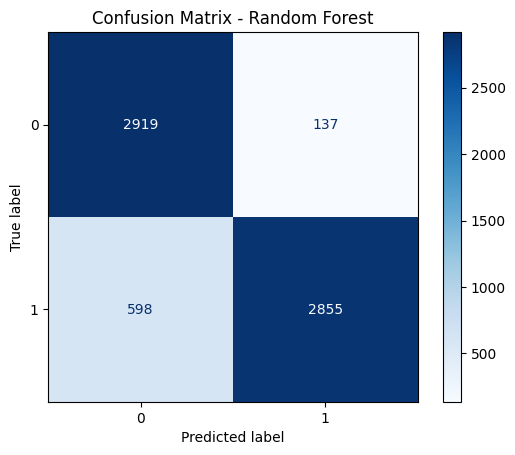


 KNN Best Model Report
              precision    recall  f1-score   support

           0       0.74      0.87      0.80      3056
           1       0.86      0.73      0.79      3453

    accuracy                           0.80      6509
   macro avg       0.80      0.80      0.80      6509
weighted avg       0.81      0.80      0.80      6509



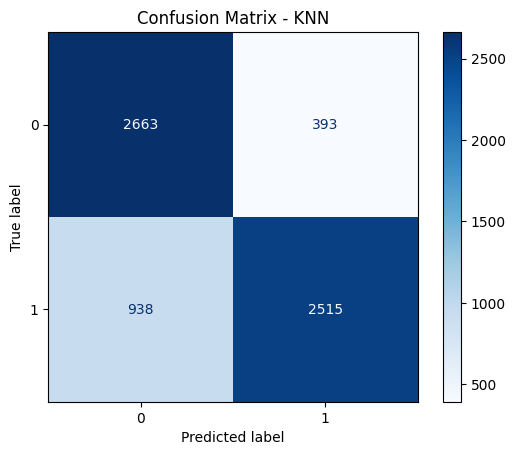


 XGBoost Best Model Report
              precision    recall  f1-score   support

           0       0.90      0.79      0.84      3056
           1       0.83      0.92      0.88      3453

    accuracy                           0.86      6509
   macro avg       0.87      0.86      0.86      6509
weighted avg       0.86      0.86      0.86      6509



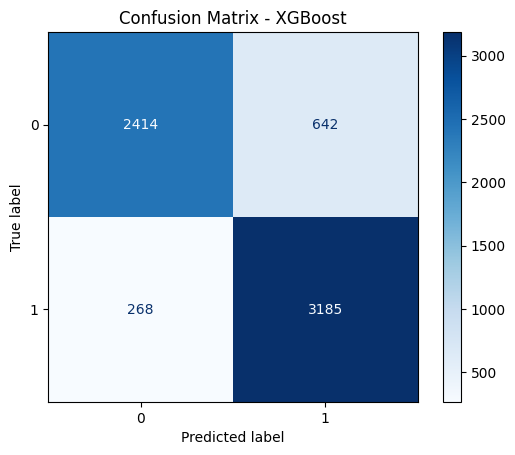


 Logistic Regression Best Model Report
              precision    recall  f1-score   support

           0       0.78      0.97      0.86      3056
           1       0.96      0.76      0.85      3453

    accuracy                           0.86      6509
   macro avg       0.87      0.86      0.86      6509
weighted avg       0.88      0.86      0.86      6509



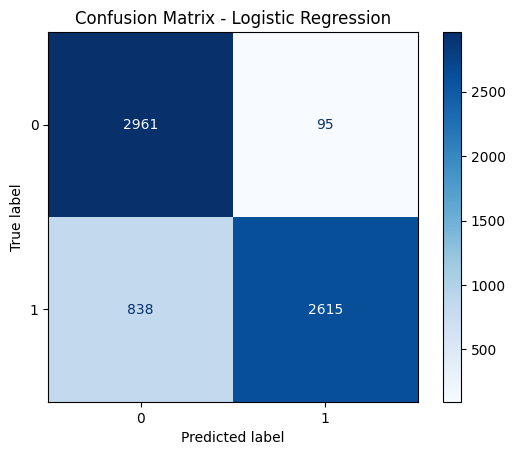


 SGDClassifier Best Model Report
              precision    recall  f1-score   support

           0       0.87      0.85      0.86      3056
           1       0.87      0.89      0.88      3453

    accuracy                           0.87      6509
   macro avg       0.87      0.87      0.87      6509
weighted avg       0.87      0.87      0.87      6509



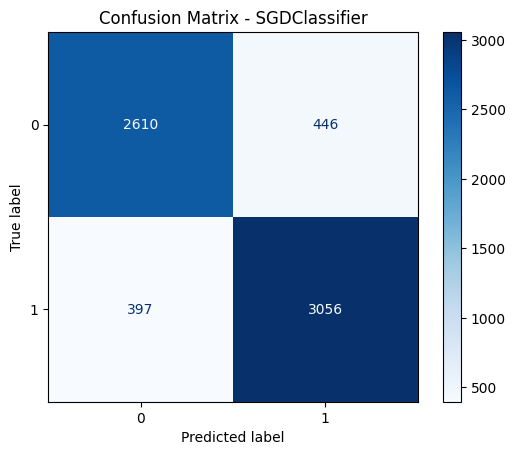

In [ ]:
from util.model_tuning import auto_model_tuning
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neural_network import MLPClassifier

base_models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "KNN": Pipeline([
        ('scaler', StandardScaler(with_mean=False)),
        ('clf', KNeighborsClassifier())
    ]),
    "SVM": Pipeline([
        ('scaler', StandardScaler(with_mean=False)),
        ('clf', SVC(random_state=42))
    ]),
    "XGBoost": XGBClassifier(random_state=42),
    "Logistic Regression": Pipeline([
        ('scaler', StandardScaler(with_mean=False)),
        ('clf', LogisticRegression(max_iter=1000, random_state=42))
    ]),
    "SGDClassifier": Pipeline([
        ('scaler', StandardScaler(with_mean=False)),
        ('clf', SGDClassifier(random_state=42))
    ]),
    # "MLPClassifier": Pipeline([
    #     ('scaler', StandardScaler(with_mean=False)),
    #     ('clf', MLPClassifier(max_iter=1000, early_stopping=True, random_state=42))
    # ])
}

param_grids = {
    "Decision Tree": {
        "max_depth":range(1,5),
        "max_leaf_nodes": range(5, 21, 5),
        "min_samples_leaf": [2 ,5, 10],
        "max_features": range(1, 11, 2)},
    "Random Forest": {
        'n_estimators': [50, 100, 200, 300, 400],
        'max_depth':[10, 20, 30],
        "min_samples_leaf": [2, 5, 10],
        },
    "KNN": {
        'clf__n_neighbors': range(3,9),
        'clf__weights': ['uniform'], ['distance']},
    "SVM": {
        'clf__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'clf__gamma': [0.01, 0.1, 1, 10, 100],
        'clf__kernel': ['linear'], ['rbf']},
    "XGBoost": {
        'n_estimators': [10, 30, 50, 100, 200, 400, 1000],
        'learning_rate' : [0.1, 0.01, 0.001],
        'max_depth': range(1,7)},
    "Logistic Regression": {
        'clf__C': [0.001, 0.01, 0.1, 1, 10, 100],  # 규제 강도
        'clf__penalty': ['l1', 'l2'],  # 규제 유형
        'clf__solver': ['saga']},
    "SGDClassifier": {
        'clf__loss': ['log_loss', 'hinge'],  # log_loss=로지스틱, hinge=SVM
        'clf__alpha': [0.0001, 0.001, 0.01],  # 규제 계수
        'clf__learning_rate': ['constant', 'adaptive'],
        'clf__eta0': [0.01, 0.1]},
    # "MLPClassifier": {
    #     'clf__hidden_layer_sizes': [(50,),],# (100,), (50, 30)],
    #     'clf__activation': ['relu', 'tanh'],
    #     'clf__alpha': [0.0001],#, 0.001],  # L2 규제 강도
    #     'clf__learning_rate_init': [0.001, 0.01],
    #     'clf__batch_size': [32]#, 64]
    }

# 함수 실행
results_df, best_models = auto_model_tuning(base_models, param_grids, X, y)